In [1]:
#Having generated alms, do the reconstuction
#and cross-correlate with true kappa
import pickle
import healpy as hp
import matplotlib
import matplotlib.pyplot as plt
import os
os.environ["DISABLE_MPI"]="true"
import numpy as np
from falafel import utils, qe
import pytempura
import solenspipe
from pixell import lensing, curvedsky, enmap
from pixell import utils as putils
from os.path import join as opj
import argparse
import yaml
from collections import OrderedDict
from cmbsky import safe_mkdir, get_disable_mpi, get_cmb_alm_unlensed, get_cmb_seeds, ClBinner
from orphics import maps
from websky_model import WebSky
from copy import deepcopy
import sys
from scipy.signal import savgol_filter
sys.path.append("../")
from reconstruction import setup_recon, setup_asym_recon

/global/common/software/act/maccrann/lenspipe/lib/python3.8/site-packages/cmbsky-0.0.1-py3.8.egg/cmbsky/utils.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  DEFAULTS=yaml.load(f)


In [2]:
def get_cl_fg_smooth(alms, alm2=None):
    cl = curvedsky.alm2cl(alms, alm2=alm2)
    l = np.arange(len(cl))
    d = l*(l+1)*cl
    #smooth with savgol
    d_smooth = savgol_filter(d, 5, 2)
    #if there's still negative values, set them
    #to zero
    d_smooth[d_smooth<0.] = 0.
    return np.where(
        l>0,d_smooth/l/(l+1),0.)

In [3]:
px=qe.pixelization(nside=4096)
mlmax=2000
lmin=1000
lmax=1500
binner=ClBinner(lmin=10, lmax=200, nbin=15)

noise_sigma_X = 2.
noise_sigma_Y = 10.
#cross-correlation coefficient 
r = 0.5

beam_fwhm=1.
ells = np.arange(mlmax+1)
beam = maps.gauss_beam(ells, beam_fwhm)
Nl_tt_X = (noise_sigma_X*np.pi/180./60.)**2./beam**2
Nl_tt_Y = (noise_sigma_Y*np.pi/180./60.)**2./beam**2
nells_X = {"TT":Nl_tt_X, "EE":2*Nl_tt_X, "BB":2*Nl_tt_X}
nells_Y = {"TT":Nl_tt_Y, "EE":2*Nl_tt_Y, "BB":2*Nl_tt_Y}

_,tcls_X = utils.get_theory_dicts(grad=True, nells=nells_X, lmax=mlmax)
_,tcls_Y = utils.get_theory_dicts(grad=True, nells=nells_Y, lmax=mlmax)
_,tcls_nonoise = utils.get_theory_dicts(grad=True, lmax=mlmax)

In [4]:
#Read in alms
ksz_alm = utils.change_alm_lmax(hp.fitsfunc.read_alm("alms_4e3_2048_50_50_ksz.fits"),
                                mlmax)
cl_rksz = get_cl_fg_smooth(ksz_alm)[:mlmax+1]
tcls_X['TT'] += cl_rksz
tcls_Y['TT'] += cl_rksz
#tcls_nonoise['TT'] += cl_rksz


cltot_X = tcls_X['TT'][:mlmax+1]-tcls_nonoise['TT']
cltot_Y = tcls_Y['TT'][:mlmax+1]-tcls_nonoise['TT']
cltot_XY = (tcls_nonoise['TT'] + r*np.sqrt(Nl_tt_X*Nl_tt_Y))[:mlmax+1]-tcls_nonoise['TT']
#We need N_l for generating uncorrelated component of Y,
#call this map Z
#We have noise_Y = a*noise_X + noise_Z
#then N_l^Y = a^2 N_l^X + N_l^Z
#and <XY> = a * N_l^X = r_l * sqrt(N_l^X N_l^Y) (from defintion of r_l)
#then we have a = r_l*sqrt(N_l^X N_l^Y) / N_l^X
#and N_l^Z = N_l^Y - a^2 N_l^X 
a = r * np.sqrt(Nl_tt_X*Nl_tt_Y)/Nl_tt_X
Nl_tt_Z = Nl_tt_Y - a**2 * Nl_tt_X

/tmp/ipykernel_6320/167959102.py:11: RuntimeWarning: invalid value encountered in true_divide
  l>0,d_smooth/l/(l+1),0.)


In [5]:
px = qe.pixelization(nside=4096)
normal_setup = setup_recon(
    px, lmin, lmax,
    mlmax,  cl_rksz, {"TT":cltot_X}
)
asym_setup = setup_asym_recon(
    px, lmin, lmax,
    mlmax,  cl_rksz, cltot_X, cltot_Y,
    cltot_XY,
    do_lh=False, do_psh=False)
asym_setup_XX = setup_asym_recon(
    px, lmin, lmax,
    mlmax,  cl_rksz, cltot_X, cltot_X,
    cltot_X,
    do_lh=False, do_psh=False)

/global/u1/m/maccrann/cmb/lensing/code/tempura/pytempura/norm.py:102: RuntimeWarning: divide by zero encountered in true_divide
  cl_tt = tcl['TT'][:k_ellmax+1]/profile**2
../reconstruction.py:186: RuntimeWarning: invalid value encountered in true_divide
  norm_Ksf = norm_K / 2 / profile
../reconstruction.py:195: RuntimeWarning: divide by zero encountered in true_divide
  N0_K_nonorm = 1./norm_K


getting point-source norm
False
False
getting lensing norm
getting source-lens response
[3.38463800e-07 2.10327417e+00 1.67877284e+00 ... 4.03226555e-06
 4.03283078e-06 4.06620669e-06]
[0.         1.45026681 1.29567453 ... 0.00191639 0.00191653 0.00192521]
 Response (TT)
getting source-point-source response


/global/u1/m/maccrann/cmb/lensing/code/tempura/pytempura/norm.py:154: RuntimeWarning: divide by zero encountered in true_divide
  cl_tt_total = tcl['TT'][:k_ellmax+1] / profile
/global/u1/m/maccrann/cmb/lensing/code/tempura/pytempura/norm.py:155: RuntimeWarning: divide by zero encountered in true_divide
  prefactor = 1./profile
/global/u1/m/maccrann/cmb/lensing/code/tempura/pytempura/norm.py:159: RuntimeWarning: invalid value encountered in multiply
  return prefactor * norm_lens.stt(k_ellmax, lmin, lmax, ucl['TT'],
../reconstruction.py:223: RuntimeWarning: divide by zero encountered in true_divide
  R_K_ps = (1./pytempura.get_norms(


[3.38463800e-07 2.10327417e+00 1.67877284e+00 ... 4.03226555e-06
 4.03283078e-06 4.06620669e-06] [8.46159499e-06 2.10328229e+00 1.67878096e+00 ... 1.26656033e-05
 1.26666951e-05 1.27005978e-05] [8.46159499e-07 8.46159512e-07 8.46159537e-07 ... 8.99306011e-07
 8.99360863e-07 8.99415746e-07]


/global/common/software/act/maccrann/lenspipe/lib/python3.8/site-packages/cmbsky-0.0.1-py3.8.egg/cmbsky/reconstruction.py:69: RuntimeWarning: divide by zero encountered in true_divide
  rlmax, TT, OCTG/(profile[:glmax+1]**2),
/global/common/software/act/maccrann/lenspipe/lib/python3.8/site-packages/cmbsky-0.0.1-py3.8.egg/cmbsky/reconstruction.py:70: RuntimeWarning: divide by zero encountered in true_divide
  OCTL/(profile[:llmax+1]**2),


(2001,) (2001,)
getting qe N0s


../reconstruction.py:96: RuntimeWarning: invalid value encountered in true_divide
  N0_XYXY_K_nonorm = noise_spec.qtt_asym(


getting qe fg_trispectrum functions
getting XY and YX qfuncs for qe
[3.38463800e-07 2.10327417e+00 1.67877284e+00 ... 4.03226555e-06
 4.03283078e-06 4.06620669e-06] [3.38463800e-07 2.10327417e+00 1.67877284e+00 ... 4.03226555e-06
 4.03283078e-06 4.06620669e-06] [3.38463800e-07 2.10327417e+00 1.67877284e+00 ... 4.03226555e-06
 4.03283078e-06 4.06620669e-06]
(2001,) (2001,)
getting qe N0s
getting qe fg_trispectrum functions
getting XY and YX qfuncs for qe


In [6]:
print(asym_setup["norm_K_XY"])
print(len(asym_setup["N0_XYXY_K"]))

[0.00000000e+00 8.28901299e-05 6.62252816e-05 ... 1.00202014e-09
 1.00098924e-09 1.00871745e-09]
2001


In [7]:
from cmbsky.utils import get_cmb_alm_unlensed
nsim=1

cl_dict = {"KK_XY" : [],
           "KK_XX_asym" : [], #using sym_setup_XX
           "KK_XX" : [], #using recon_setup
           "KK_XYxi" : [],
           "KK_XXxi" : [],
           "KK_XY_kszonly" : [],
           "KK_XX_kszonly" : [],
           "KK_XY_noksz" : [],
          }
do_qe=True
rank,size=0,1

#do ksz only
Xf_ksz, Yf_ksz = asym_setup["filter_X"](ksz_alm.copy()), asym_setup["filter_Y"](ksz_alm.copy())
if rank==0:
    print("rank 0 doing ksz only")
    K_XY_kszonly = asym_setup["qfunc_K_XY"](Xf_ksz, Yf_ksz)
    K_XX_kszonly = normal_setup["qfunc_K"](Xf_ksz,Xf_ksz)
    cl_dict["KK_XY_kszonly"] = binner(curvedsky.alm2cl(
        K_XY_kszonly
    ))
    cl_dict["KK_XX_kszonly"] = binner(curvedsky.alm2cl(
        K_XX_kszonly
    ))

rank 0 doing ksz only


/global/common/software/act/maccrann/lenspipe/lib/python3.8/site-packages/healpy/sphtfunc.py:822: UserWarning: Sigma is 0.000000 arcmin (0.000000 rad) 
  warnings.warn(
/global/common/software/act/maccrann/lenspipe/lib/python3.8/site-packages/healpy/sphtfunc.py:827: UserWarning: -> fwhm is 0.000000 arcmin
  warnings.warn(
/global/u1/m/maccrann/cmb/lensing/code/falafel/falafel/qe.py:474: RuntimeWarning: divide by zero encountered in true_divide
  salm=cs.almxfl(salm,1./profile)


In [8]:
for isim in range(nsim):
    if size>1:
        if isim%size != rank-1:
            continue
    print("rank %d doing sim %d"%(rank,isim))
    print("reading cmb  alm")
    cmb_alm = get_cmb_alm_unlensed(isim,0)[0]*0.
    cmb_alm = utils.change_alm_lmax(cmb_alm, mlmax)
    ells = np.arange(mlmax+1)
    cl_dict["ells"] = ells

    print("generating noise")
    noise_alm_X = curvedsky.rand_alm(Nl_tt_X, seed=isim*(10*nsim))
    noise_alm_Z = curvedsky.rand_alm(Nl_tt_Z, seed=isim*(10*nsim)+1)
    noise_alm_Y = curvedsky.almxfl(noise_alm_X,a) + noise_alm_Z

    X_ksz = ksz_alm.copy()
    X = cmb_alm+noise_alm_X+ksz_alm
    Y = cmb_alm+noise_alm_Y+ksz_alm
    Xf, Yf = asym_setup["filter_X"](X), asym_setup["filter_Y"](Y)
    Xf_ksz, Yf_ksz = asym_setup["filter_X"](ksz_alm.copy()), asym_setup["filter_Y"](ksz_alm.copy())

    X_noksz = cmb_alm+noise_alm_X
    Y_noksz = cmb_alm+noise_alm_Y
    Xf_noksz, Yf_noksz = asym_setup["filter_X"](X_noksz), asym_setup["filter_Y"](Y_noksz)

    #X_fg_gaussian = curvedsky.rand_alm(cl_fg_X, seed=isim*(10*nsim)+3)
    #Y_fg_gaussian = 0.1*X_fg_gaussian

    print("running K estimators")
    if do_qe:
        print("qe case:")
        K_XY = asym_setup["qfunc_K_XY"](Xf, Yf)
        K_XX_asym = asym_setup_XX["qfunc_K_XY"](Xf,Xf)
        K_XX = normal_setup["qfunc_K"](Xf,Xf)

        print("running no ksz case")
        K_XY_noksz = asym_setup["qfunc_K_XY"](Xf_noksz, Yf_noksz)

        #auto
        cl_dict["KK_XY"].append(binner(
            curvedsky.alm2cl(K_XY)
        ))
        cl_dict["KK_XX_asym"].append(binner(
            curvedsky.alm2cl(K_XX_asym)
        ))              
        cl_dict["KK_XX"].append(binner(
            curvedsky.alm2cl(K_XX)
        ))
        cl_dict["KK_XY_noksz"].append(binner(
            curvedsky.alm2cl(K_XY_noksz)
        ))
        cl_dict["KK_XYxi"].append(binner(
            curvedsky.alm2cl(K_XY, K_XY_kszonly)
        ))
        cl_dict["KK_XXxi"].append(binner(
            curvedsky.alm2cl(K_XX, K_XX_kszonly)
        ))
        

rank 0 doing sim 0
reading cmb  alm
generating noise
running K estimators
qe case:
running no ksz case


In [9]:
for key in cl_dict:
    cl_dict[key] = np.array(cl_dict[key])
    
ksz_only_tri_XX = normal_setup["get_fg_trispectrum_K_N0"](cl_rksz)
ksz_only_tri_XY = asym_setup["get_fg_trispectrum_N0_XYXY"](cl_rksz, cl_rksz, cl_rksz)

../reconstruction.py:255: RuntimeWarning: divide by zero encountered in true_divide
  Ctot = tcls_X['TT']**2 / cl_fg
../reconstruction.py:261: RuntimeWarning: invalid value encountered in true_divide
  return N0_K**2 / norm_fg


(2001,)


../reconstruction.py:116: RuntimeWarning: invalid value encountered in true_divide
  N0_tri_XYXY_prof_nonorm /= profile**2


In [17]:
print(cl_dict["KK_XY"])

[[5.46602260e-05 1.36291214e-05 4.50424459e-06 1.81814979e-06
  9.49991097e-07 4.41460045e-07 2.57324583e-07 1.50171783e-07
  9.04088663e-08 6.13679101e-08 4.34277607e-08 3.12222590e-08
  2.36050498e-08 1.79422260e-08 1.44973832e-08]]


In [ ]:
%matplotlib inline

#plot signal

fig,ax=plt.subplots()
ax.plot(

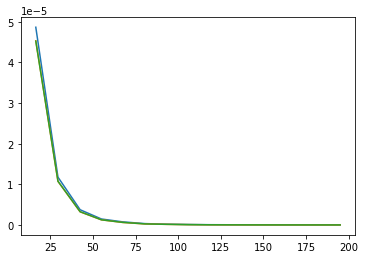

In [21]:
%matplotlib inline

#plot signal

fig,ax=plt.subplots()
ax.plot(binner.bin_mids, cl_dict["KK_XY"].mean(axis=0)-binner(asym_setup["N0_XYXY_K"]))
#ax.plot(binner.bin_mids, binner(asym_setup["N0_XYXY_K"]))
ax.plot(binner.bin_mids, cl_dict["KK_XX_kszonly"]-binner(ksz_only_tri))
ax.plot(binner.bin_mids, cl_dict["KK_XYxi"].mean(axis=0)-binner(ksz_only_tri))
#ax.plot(binner.bin_mids, (cl_dict["KK_XY"].mean(axis=0)-binner(asym_setup["N0_XYXY_K"]))/cl_dict["KK_XX_kszonly"])
#ax.plot(binner.bin_mids, binner(cl_dict["K_XX_kszonly"]))

KeyError: 'K_XX_kszonly'

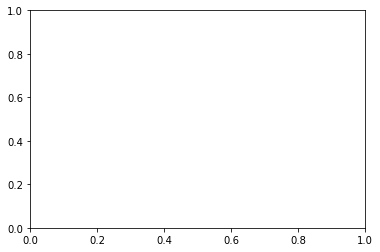

In [17]:
%matplotlib inline

#plot signal

fig,ax=plt.subplots()

cl_KK = binner(cl_dict["K_XX_kszonly"])

ax.plot(binner.bin_mids, (cl_dict["KK_XY"].mean()-binner(asym_setup["N0_XYXY_K"]))/cl_KK-1)
ax.set_yscale('symlog')

fig.savefig("signal_XY_test_nsim%d.png"%nsim)

(array([           nan, 1.52546059e+02, 1.23407061e+02, ...,
       6.52915533e+07, 6.53253265e+07, 6.58939872e+07]),)


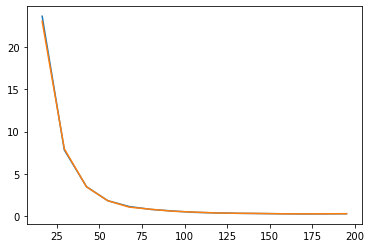

In [9]:
%matplotlib inline

fig,ax=plt.subplots()

print(asym_setup["N0_XYXY_K"])

N0_XY = binner(asym_setup["N0_XYXY_K"])
N0_XX = binner(normal_setup["N0_K"])

ax.plot(binner.bin_mids, binner(asym_setup["N0_XYXY_K"][0]))
ax.plot(binner.bin_mids, cl_dict["KK_XY_noksz"][0])
#ax.set_yscale('log')

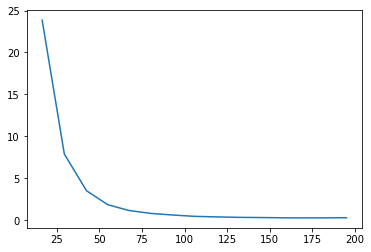

In [13]:
%matplotlib inline

fig,ax=plt.subplots()

#ax.plot(binner.bin_mids, (cl_dict["KK_XY_noksz"][0]))
ax.plot(binner.bin_mids, N0_XY)
ax.plot(binner.bin_mids, binner(asym_setup["norm_K_XY"]))
#ax.set_yscale('log')